In [27]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

import os
import joblib
import pickle

import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns

import stability as st

import statistics
import scipy as scp
import math
import random

import lime
from lime import lime_tabular

from collections import Counter

import shap

In [28]:
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/Breast Cancer/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/Breast Cancer/"
model_filename = os.path.join(PATH, "models/diabetes_xgb.joblib")
dataset_path = 'datasets/'
model = joblib.load(model_filename)

In [29]:
tn_file = os.path.join(PATH, "datasets/dicts/false_neg.pkl")
with open (tn_file, 'rb') as f:
    results = pickle.load(f)
    
f.close()

In [30]:
X_train = pd.read_csv(PATH + "datasets/breast_cancer_Xtrain.csv", index_col=False).values
X_test = pd.read_csv(PATH + "datasets/breast_cancer_Xtest.csv", index_col=False).values
X_validation =pd.read_csv(PATH + "datasets/breast_cancer_Xvalidation.csv",index_col=False).values
y_train = pd.read_csv(PATH + "datasets/breast_cancer_Ytrain.csv",index_col=False).values
y_test =pd.read_csv(PATH + "datasets/breast_cancer_Ytest.csv", index_col=False).values
y_validation = pd.read_csv(PATH + "datasets/breast_cancer_Yvalidation.csv", index_col=False).values

original_data = pd.read_csv(PATH + "datasets/breast_cancer.csv")
original_data = original_data.dropna(axis = 'columns')
original_data = original_data.drop(['id'], axis = 1)
feature_names = original_data.drop(["diagnosis"], axis = 1).columns

In [31]:
feature_names

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [32]:
MAX_FEAT = 10

start_time = time.time()

# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names, 
                                                  class_names=["Benign", "Malignant"], verbose=False, mode='classification')

elapsed = time.time() - start_time

print ("Time taken to create explainer:", round(elapsed, 2), "seconds")

Time taken to create explainer: 0.01 seconds


In [33]:
stability_scores = []
probas = []
changes = []
feat_list = list(feature_names)

for instance in results:
    print ("Running instance", results.index(instance))
    
    feat_pres = []

    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][0]
    probas.append(p1)
    
    start_time = time.time()
    # explain instance
    explanations = []
    
    for iteration in range(3):
        print("Explaining instances - Run", iteration)
        lime_exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = MAX_FEAT)
        explanation = lime_exp.as_list()
        explanations.extend(explanation)
    
    features = []
    for explanation in explanations:
        features.append(explanation[0])

    print("Removing duplicates")
    counter = Counter(features)
    check_dup = []
    for feat in feat_list:
        for feature in counter:
            if feat in feature:
                check_dup.append(feat)

    dup_counter = Counter(check_dup)
    duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

    for each in duplicated:
        dpls = []
        vals = []
        for feat in counter.keys():
            if each in feat:
                dpls.append(feat)
                vals.append(counter[feat])
        keepval = vals.index(max(vals))
        for i in range(len(dpls)):
            if i != keepval:
                del counter[dpls[i]]

    rel_feat = counter.most_common(MAX_FEAT)
    
    intervals = []

    for item in rel_feat:
        print("Creating distribution for feature", rel_feat.index(item))
        feat = item[0]
        #print(item)
        #print(feat)
        for n in range(len(feat_list)):
            if feat_list[n] in feat:
                if ("<" or "<=") in feat and (">" or ">=") in feat:
                    two_sided = True
                    parts = feat.split(' ')
                    l_bound = float(parts[0])
                    u_bound = float(parts[-1])
                    interval = u_bound - l_bound
                    new_min = u_bound
                    new_max = u_bound + interval
                else:
                    two_sided = False
                    parts = feat.split(' ')
                    if parts[-2] == "<=" or parts[-2] == "<":
                        u_bound = float(parts[-1])
                        if u_bound != 0:
                            interval = math.ceil(u_bound*1.1)
                        else:
                            interval = 5
                        new_min = u_bound
                        new_max = u_bound + interval
                    elif parts[-2] == ">=" or parts[-2] == ">":
                        l_bound = float(parts[-1])
                        if l_bound != 0:
                            interval = math.ceil(l_bound*1.1)
                        else:
                            interval = 5
                        new_max = l_bound
                        new_min = l_bound - interval
                    else:
                        bound = float(parts[-1])
                        interval = math.ceil((bound*1.1)/2)
                        new_min = bound
                        new_max = bound+interval
                feature_name = feat_list[n]
                index = n
                int_min = new_min
                int_max = new_max
                intervals.append((feature_name, index, int_min, int_max))
        
    #print("List of changes:", intervals)

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)

    changes.append(np.mean(diffs))#np.std(diffs))
    #each['lime_fid_change'] = diff#s
    #print("RMSE for instance:", np.std(diffs))
 


Running instance 0
INDEX = 41
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Running instance 1
INDEX = 55
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution fo

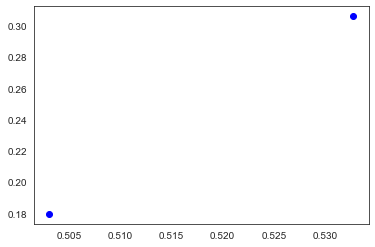

In [34]:
plt.plot(probas, changes, 'bo')
plt.show()

In [35]:
#RMSE
sq_changes = []
abs_changes = []
for each in changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
  #  change = probas[i] - changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.06294593285753536
RMSE: 0.2508902805162754
MAE: 0.24279499799013138
MAPE: 0.46567702293395996


# SHAP

In [36]:
X_train_frame = pd.DataFrame(data = X_train, columns = feature_names)
X_test_frame = pd.DataFrame(data = X_test, columns = feature_names)

data_sample = shap.kmeans(X_train_frame, 100)
shap_explainer = shap.KernelExplainer(model.predict_proba, data_sample)#, link = 'identity')

shap.initjs()

In [37]:
shap_values = shap_explainer.shap_values(X_test_frame)
shap_val_feat = np.transpose(shap_values[0])
feats = np.transpose(X_test_frame.values)

0
-0.0030866351963179384 19
-0.0036449922739927587 19
-0.003956744670845114 19
0.0 19
0.0036358209072678838 20
-0.0022329097558594913 19
0.003433776506573949 20
-0.0031343616275636976 19
0.001174924428566121 20
-0.003410278879316442 19
-0.004045052637271951 19
0.0019220042212046984 20
-0.003521201641397631 19
-0.0031433715950339447 19
0.0015026740478200074 20
0.002252861865834954 20
-0.0019151923326109765 19
0.0027966276453701144 20
0.0 19
-0.0012868377468714387 19
0.003935016302431732 20
0.0038953762054508845 20
0.001149087082180228 20
0.0026445606098790264 20
-0.00249799498941748 19
0.003073631702195073 20
0.0025183586242122358 20
-0.0018830334189978704 19
0.0021206607939887323 20
0.0028353159868227673 20
-0.0023730172339455347 19
0.002721216428829526 20
0.0034567359339918724 20
-0.003485105802442323 19
0.0028727206571410036 20
0.0 19
0.0 19
0.0 19
-0.0038477589866089956 19
-0.0029088019764044806 19
0.0 19
0.0 19
0.0013656846807348355 20
0.0011583139056963176 20
0.002586618893045428 

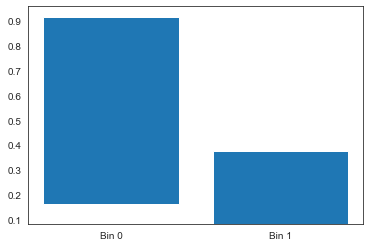

1
-0.006418329601309974 19
-0.00389405540381621 19
-0.004635433582039439 19
0.003367945959891372 20
0.0 19
-0.003417268958557207 19
0.0 19
-0.003999609306151064 19
0.0 19
-0.0030767410409825446 19
-0.002416860674093746 19
0.0 19
-0.002951419421750451 19
0.02017186218643198 20
0.0 19
0.005375481739990112 20
-0.003106611719711161 19
0.0 19
-0.0035803940779463583 19
-0.004166315473692395 19
0.0 19
0.0 19
0.0 19
0.0 19
0.017141216385220415 20
0.0 19
0.0 19
-0.001597520672556918 19
0.0 19
0.0 19
-0.002988967543698706 19
0.007192730188648633 20
0.004660844694983068 20
-0.004674260126051266 19
0.0 19
-0.0016609973446077009 19
0.0 19
0.0031615592112185786 20
-0.0026784179164520416 19
0.01402027028243932 20
0.0 19
-0.00450464588286742 19
0.00667872435935607 20
0.0005621217357644481 20
0.005972350995781334 20
-0.0029145731413371956 19
0.0 19
0.006695496811896906 20
0.0 19
0.0 19
0.007194148993766886 20
-0.005822254650406228 19
-0.003411400177220747 19
-0.002735561976759976 19
0.0 19
-0.001823972

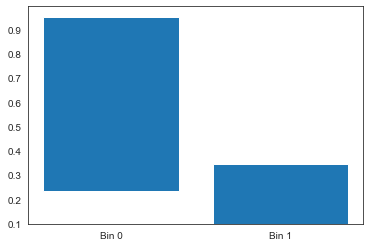

2
-0.002101554816868717 19
-0.0024582530863029306 19
-0.001922526154843729 19
0.0012340261225579907 20
0.0 19
-0.0041942284631108495 19
0.003284279131761214 20
-0.002445031967665462 19
0.0 19
-0.003763389004466766 19
-0.0012673135402445634 19
0.004060002412855812 20
-0.0020825559207549027 19
-0.0018895147880848007 19
0.0018494715306561216 20
0.0 19
-0.003357852866505029 19
0.0 19
-0.004690499588154817 19
-0.0027579873021655044 19
0.003132561600734718 20
0.0027055668289742707 20
0.002010335759882076 20
0.0015786163161433386 20
0.0 19
0.0019392621640811902 20
0.001588765371102474 20
0.0 19
0.0020245607383236053 20
0.002940059105470766 20
-0.00397203206323693 19
0.002683367722516955 20
0.004302063707191828 20
-0.0022211528114561563 19
0.0 19
0.0 19
0.0030718106331659462 20
0.0009577906269168657 20
-0.0020224558531562464 19
-0.001985618200525091 19
0.003352591340958876 20
-0.0029908320788052667 19
0.003045757956768841 20
0.002839967040150826 20
0.0020413541583342854 20
-0.00337440800366564

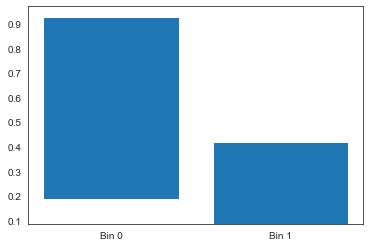

3
0.0 19
-0.003568173060733315 19
-0.0017858514815363435 19
0.0011846826743557304 20
0.0018195515184298017 20
-0.0033408475749982236 19
0.002592891888286264 20
-0.000843012733160925 19
0.002247790453842574 20
-0.001706339991500827 19
-0.0015689154006642836 19
0.0012885063203062624 20
-0.00456004498620638 19
0.0 19
0.0022915440635531414 20
0.001251277513556831 20
-0.003167821672734633 19
0.0 19
-0.0023889806508018696 19
-0.002554948294932302 19
0.0 19
0.004399915969403589 20
0.00288305516811288 20
0.0021646809307560577 20
-0.003387457059387141 19
0.0 19
0.0 19
-0.0036268968250799394 19
0.0035536672743672892 20
0.002028404890830532 20
-0.0024687513985994503 19
0.0031413632201238995 20
0.0040424167993861615 20
-0.003961734762203961 19
0.002257811109925678 20
0.0 19
0.002464982185649444 20
0.002349691641346796 20
-0.004501106117381248 19
0.0 19
0.0 19
-0.0029295721152975407 19
0.0037740204395751153 20
0.003127587329927739 20
0.004383158460474407 20
-0.004739009239523917 19
0.00395918060076

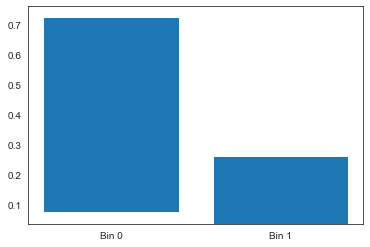

4
-0.0021970460223222354 19
0.0 19
-0.0008767856841441213 19
0.008150208475779713 20
0.0 19
-0.003318645135270859 19
0.0 19
-0.0014436132756225073 19
0.0045727732932332454 20
-0.0016215148504769294 19
-0.00138883288311481 19
0.0 19
0.0 19
0.0 19
0.003977909334138996 20
0.0 19
-0.0019350590257474487 19
0.002203885402889738 20
0.0 19
-0.0021686616531102765 19
0.0 19
0.0 19
0.0 19
0.0013474634390125972 20
0.007445573354132453 20
0.0 19
0.0 19
-0.0013708242059735087 19
0.0 19
0.0 19
-0.0007689988142541293 19
0.0 19
0.0 19
-0.0036634747130992185 19
0.0 19
0.0 19
-0.0025947048848505728 19
0.0 19
-0.0015269771545736166 19
-0.0016926060412446736 19
0.0 19
-0.0017865999827874068 19
0.0029091204749931154 20
0.004700204942344022 20
0.005982787936826994 20
-0.0014103929480663857 19
0.0 19
0.0009068653035200769 20
0.0 19
0.0 19
0.0009048868074346961 20
0.004299795592074621 20
0.0 19
0.0 19
0.0 19
-0.0025202230567564765 19
0.0 19
0.007757855987629625 20
0.0 19
0.0 19
0.0 19
0.008211856993279643 20
-

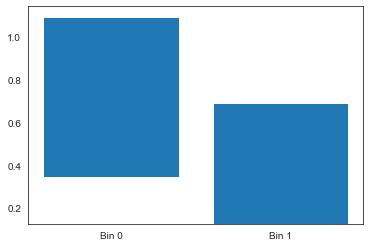

5
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.001005922927854619 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0011736896440864009 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0008518168928033365 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0016088441212699367 20
0.0 19
-0.000841436821473529 19
0.0 19
0.0 19
0.0 19
0.0013512149073905133 20
0.0 19
0.0 19
0.000661280508872375 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0010222038747840778 20
0.0010375744842778534 20
0.0 19
-0.0018868516337156027 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.001477789487857234 19


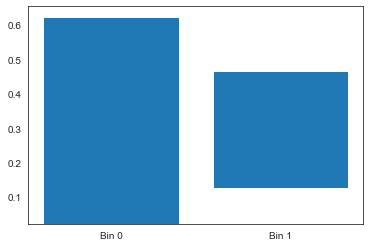

6
-0.01978612853594819 19
-0.01353626428708185 19
-0.012662639373661883 19
0.01252872296544394 20
0.013185350029557785 20
-0.012660080373812277 19
0.013076299506111277 20
-0.013470078193502377 19
0.012814902350545831 20
-0.011945968291864367 19
-0.013331709965013039 19
0.010904096451443385 20
0.011569213273369738 20
-0.016198695670589958 19
0.014002371920920714 20
0.013504851288573483 20
-0.013330302646999193 19
0.013679672206102278 20
-0.013838641859430428 19
-0.019400884419888853 19
0.01399640991619841 20
0.014346825119546464 20
0.01466746362836846 20
0.016551826151684684 20
0.009544749946011621 20
0.012290654180733274 20
0.012655716452826593 20
0.0 19
0.012035225537481709 20
0.012520071559238788 20
-0.013781899358460803 19
0.013459022739880505 20
0.013120801475950072 20
-0.013593079788874557 19
0.009058052938582972 20
0.0 19
-0.012035997913648077 19
0.01410331449779173 20
-0.01281089637422124 19
-0.021702165925518255 19
-0.012087675284765011 19
-0.012778261579407646 19
0.01103981194

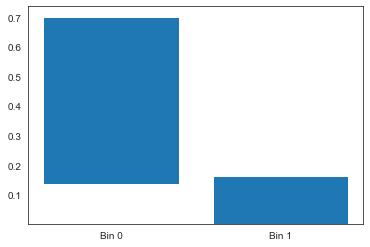

7
-0.0788818011392691 18
-0.04693867832627957 19
-0.05173457107568735 18
0.04181216890703757 20
0.03976814559467182 20
-0.045690647835985365 19
0.041320960269753515 20
-0.043084018340908636 19
0.04651162690338412 20
-0.04689372904622091 19
-0.0467126715893221 19
0.04209368469559521 20
-0.0213968450595054 19
-0.06929910212248039 18
0.04374893573813396 20
0.05096036004140772 21
-0.04338327280360002 19
0.04545105294738433 20
-0.05645880471915493 18
-0.08419065543115373 18
0.043684025830085405 20
0.04178348928841952 20
0.04327455367355612 20
0.041558291048720164 20
0.01764603855247447 20
0.04187980464447594 20
0.042913999685824045 20
-0.044013677412314545 19
0.04472568741517191 20
0.04122333338890172 20
-0.04213081159978671 19
0.0428730372443438 20
0.04201201481842276 20
-0.04556548151407025 19
0.05088496136000184 21
0.029787116639481914 20
-0.06340458657139668 18
0.04301620651674265 20
-0.04753236644633255 19
-0.08622219622180663 18
-0.058277983459281694 18
-0.04715062578435572 19
0.04086

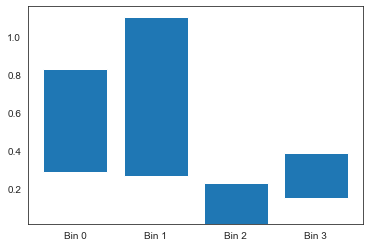

8
0.0 19
0.0 19
-0.0019316958212393653 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0012047734663332144 19
-0.002264126786665821 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.007878742608156658 20
0.0 19
0.0 19
0.0 19
0.022760943647587933 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.001431109940389752 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.009068262368403246 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0009044842131862574 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0010662355416268254 19


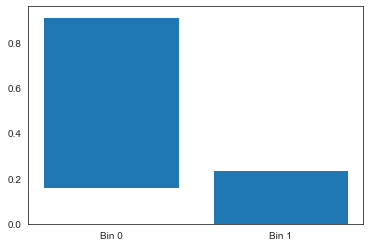

9
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0008368410999868292 20
0.0 19
0.0 19
0.0 19
0.0 19
0.011912415349483807 20
0.0 19
0.0 19
0.0 19
0.007077546173529785 20
0.0 19
0.0010613263229572734 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.003108199009134255 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


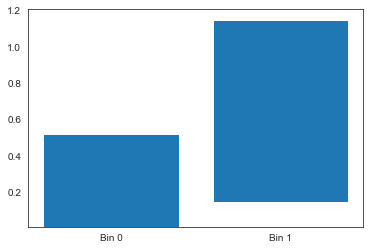

10
0.0 19
0.0 19
-0.001835594295657883 19
0.01483213801293079 20
-0.014592474629197272 19
-0.006726459817852665 19
0.0042909523789935455 20
-0.005576859592749117 19
0.0024642764348143387 20
0.0 19
0.0 19
0.01003517519551747 20
-0.0074546493237812594 19
0.0 19
0.003667586075433882 20
0.0033476617051362845 20
-0.006548943858184664 19
0.004512680743556041 20
0.0 19
0.0 19
0.0033128243534027713 20
0.0 19
0.0015851430492331287 20
0.0018958861335330313 20
0.0 19
0.004427934769373781 20
0.0031074505871795666 20
0.0 19
0.005188447335191804 20
0.0027837227533460684 20
-0.005311600788502152 19
0.002858271777348015 20
0.0 19
0.0 19
0.004166697352126575 20
0.0 19
0.0012149565240275602 20
0.0029121607839239505 20
0.0 19
0.0 19
0.0 19
0.0 19
0.015717822438096746 20
0.0035806557192428756 20
0.004613853570974297 20
-0.0048340727819882745 19
0.0027456758115533275 20
0.016169566347622566 20
0.0 19
0.0 19
0.002164833464195437 20
0.0031181863211815902 20
0.0 19
-0.006672964119453451 19
-0.0221786166130902

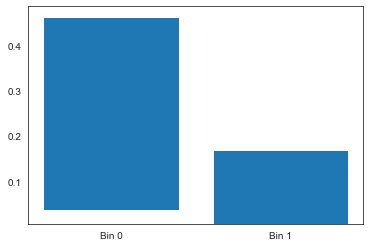

11
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0016292245652614334 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0004730050135252073 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0010213645051046494 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0016838936876696908 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007318611685783738 20
0.0 19
0.0 19
0.0 19
-0.0038130581364457378 19
0.0 19
0.0 19
0.018098334776555036 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


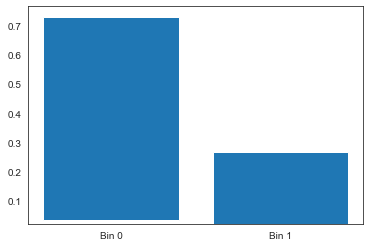

12
0.0 19
0.0 19
0.0 19
0.003913058801500641 20
0.0 19
-0.00389417660338115 19
0.0 19
-0.003066588835116041 19
0.0 19
0.0 19
-0.0019685198413201543 19
0.0012792952690143522 20
-0.0023844257288875015 19
-0.005366861984543753 19
0.001336246275212033 20
0.0018101384116429864 20
-0.0027781513574410277 19
0.0 19
0.0 19
0.0 19
0.0005675899080534175 20
0.0 19
0.0010687328614193414 20
0.0012474287653538862 20
0.0 19
0.0010753170849281957 20
0.001493226797506353 20
0.0 19
0.0 19
0.0 19
-0.004450953747628189 19
0.0014595559571119465 20
0.002069577504538872 20
0.0 19
0.0024687594051372996 20
0.0 19
0.0 19
0.001746398459755133 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0037000467206882437 20
0.0008233033775506826 20
0.0 19
-0.0025609950313546515 19
0.002067866330889012 20
0.004959132228871982 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.004170664264720125 19
-0.0073169071807868 19
0.0 19
0.0015401848952010244 20
0.0 19
0.0 19
0.005754050609266592 20
0.0 19
0.0013240077235874281 20
-0.0022260175859576403 19


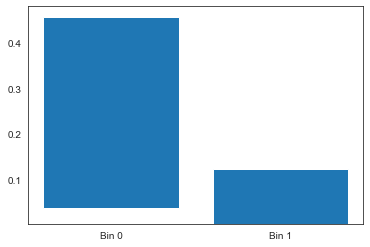

13
-0.004364889643785785 19
-0.0465331400751679 19
-0.0137916250543971 19
0.03652667975012791 20
-0.006873903540948717 19
-0.047902122329928215 19
0.02221472326699664 20
-0.04201189520517443 19
0.009652658752274945 20
-0.049640510493600076 19
-0.046903014427898654 19
0.03183587731679316 20
-0.056669933728218796 18
-0.08413374100231238 18
0.02795719798142171 20
0.026300522602430015 20
-0.046518012084317745 19
0.026554569199200295 20
-0.006280236532757277 19
-0.005269227713810415 19
0.023018898700072732 20
0.027446643751539435 20
0.027086663507966513 20
0.0336805385797061 20
-0.06412671714490822 18
0.026107586318873804 20
0.034825157101620374 20
-0.004145454802730514 19
0.03436765988779519 20
0.03333755075126846 20
-0.04713701480042404 19
0.02747743872829228 20
0.021889477306911154 20
-0.04593743157460689 19
0.03131491379496182 20
-0.015685903565015924 19
0.006822940533630402 20
0.02537354926714691 20
-0.04824243951652249 19
-0.010283715173877273 19
0.02411872203495784 20
-0.047186405352

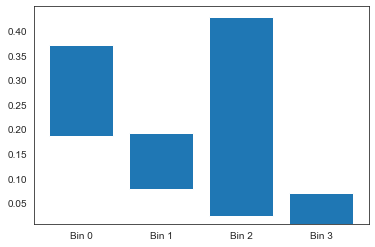

14
0.0 19
0.0 19
0.0 19
0.002006972333362056 20
0.0 19
0.0 19
0.0017076945722870607 20
0.0 19
0.002235241392709836 20
0.0 19
0.0 19
0.0011514630506406498 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0013866641832839255 20
-0.03781177891268178 19
0.0 19
0.0021879940016646393 20
0.0 19
-0.01252584761296277 19
0.0 19
0.0 19
0.0 19
0.0 19
0.000659273062978083 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0015516746515285285 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0015138455428305164 20
0.0009105521956065676 20
0.0 19
-0.0019702635881418407 19
0.0008445455057602691 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.02358118709671847 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


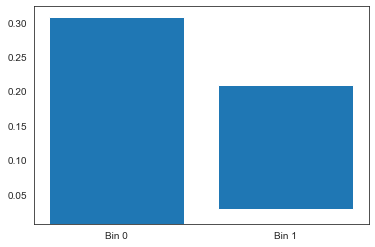

15
0.0 19
0.0 19
-0.0008905513051259417 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0008581931972073686 19
0.0010177722169399661 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0006301166034864414 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0010234816108185552 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


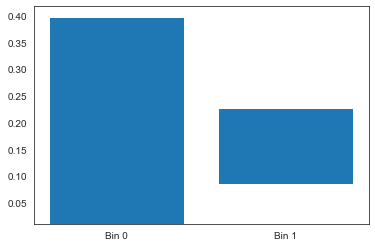

16
-0.0025398413644602547 19
0.0 19
-0.0015083336960549087 19
0.003968884086782004 20
0.0 19
0.0 19
0.0 19
-0.0008065892237528183 19
0.0020236421051632036 20
0.0 19
-0.0015128372480972818 19
0.0 19
-0.0016802913496702376 19
0.0 19
0.003998234407196488 20
0.0 19
0.0 19
0.0 19
0.0 19
-0.0013404549274697863 19
0.004747284993790096 20
0.0 19
0.0027134062314981555 20
0.0 19
0.003973986216520487 20
0.0 19
0.0009726355476724069 20
0.0 19
0.0 19
0.001034753268480626 20
-0.001151862960876271 19
0.0 19
0.0030914503726654774 20
-0.0014530808403982187 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007150770991081468 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0021736705499840747 19
-0.001516618208468823 19
0.0 19
0.0 19
0.0 19
0.0 19
0.003267236926751793 20
0.0 19
0.0 19
0.0 19
-0.0012719020541860915 19


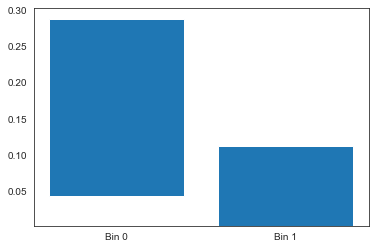

17
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0008660661574086959 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0003807849437331423 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0008845780149476234 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.000770960472728538 20
0.0 19
0.0 19
0.0 19
-0.0007400681105332874 19


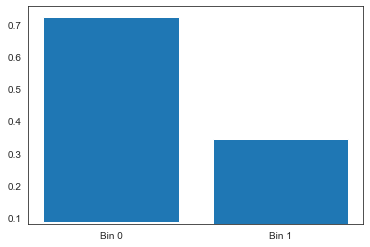

18
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0014171855305052106 19
0.0 19
-0.001016776992482732 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0018600894003117374 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.001588271376130864 20
0.0010292910817804313 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.00040220096090440305 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0012492632493948386 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


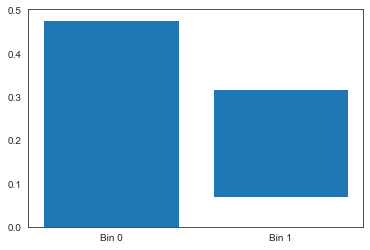

19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.001024953002507989 19
0.0 19
-0.0016048112134706138 19
-0.001554203937672527 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007775208377812648 20
0.0 19
0.0 19
0.0010653707633163922 20
0.0 19
0.0 19
0.0019410549250715448 20
-0.0012177355501097331 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0017671130826438161 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007284859362661489 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


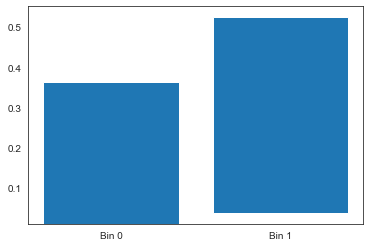

20
-0.034816949051899165 19
-0.08353070945158142 18
-0.08733983757655484 18
0.06185314911118961 21
0.07816264175510851 21
-0.0821159127179718 18
0.0843609160543825 21
-0.0816127479456481 18
0.07630231653390138 21
-0.08560101073582027 18
-0.08502707495353112 18
0.07299748040977888 21
-0.0847428850438488 18
-0.00804630781692954 19
0.08015870756588722 21
0.10069949756070698 22
-0.0822802177678576 18
0.0803821699603337 21
-0.09315358040155183 18
-0.0337050358289942 19
0.07485557014218142 21
0.08470873835925025 21
0.08007403647311076 21
0.0723469285220725 21
-0.06963502055635451 18
0.08170403641088925 21
0.07841515573083785 21
-0.09882384370891867 18
0.078930044207591 21
0.07793843611283441 21
-0.08279454591586977 18
0.07800923227473483 21
0.07890706686954693 21
-0.08625388049014271 18
0.11041743643681157 22
-0.129770118181802 17
0.07947834944112436 21
0.07699212095869781 21
-0.0849282898687079 18
-0.006467358642594664 19
0.07523195563481916 21
-0.0846145105135021 18
0.06682794611726695 21


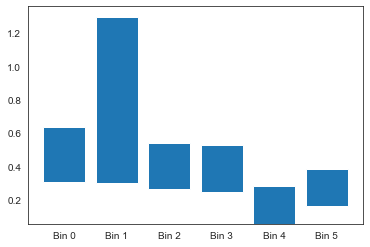

21
-0.02038539912709636 19
-0.009201738818569727 19
-0.02107409073484967 19
0.009221892967285178 20
-0.03867990410643221 19
-0.0016660197646281294 19
0.007436849665211853 20
-0.020246498350583175 19
0.00662624837735365 20
-0.0026311973097732644 19
-0.0021373159137367537 19
-0.03893386758266812 19
-0.0028400930277682757 19
0.044400547762661 20
0.007754571991803461 20
0.021967437766002518 20
-0.008546572771051891 19
0.008528733593200583 20
-0.0024218245621747403 19
0.0 19
-0.048431167249938234 19
0.007491137943958948 20
0.008969514360952058 20
0.009091739905454033 20
0.029755138104261954 20
0.007911313821494848 20
0.007708658314967254 20
-0.0015449556796792163 19
0.006191560727859036 20
0.0 19
-0.00863139906879798 19
0.02160777666821828 20
0.021121192143850887 20
-0.0025223978268003877 19
0.005979778462619489 20
-0.009248436807878346 19
0.004097434232521014 20
0.0102572419057603 20
-0.002310727222596426 19
0.05347471488029179 21
-0.0065536957274718415 19
-0.002055487383501059 19
0.006846

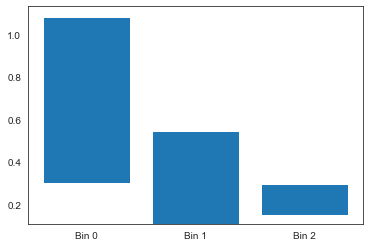

22
-0.12361048373371292 17
-0.108816973777219 17
-0.10545541345372872 17
0.09733715346571942 21
0.107093447639861 22
-0.10474470901681215 17
0.11165264106479941 22
-0.10447430297798477 17
0.10631309450743914 22
-0.10717050800899383 17
-0.1084732512185484 17
0.1111048004347317 22
-0.10241338073803413 17
-0.08365450232962271 18
0.10163384680784765 22
0.11149208733270993 22
-0.10741945361359417 17
0.10750379176482655 22
-0.11829722148272678 17
-0.1204752502001088 17
0.09999524273650506 21
0.11255693224722543 22
0.10431857625547936 22
0.1125367101951488 22
-0.0554418277848046 18
0.11410021197472908 22
0.11151055773438984 22
-0.11362542064010384 17
0.11286300016903328 22
0.11048232018655485 22
-0.10661706972670765 17
0.09436687246474273 21
0.09384236857207912 21
-0.10874610574117857 17
0.12540245198947964 22
-0.1115920924860459 17
0.10335439267948962 22
0.08039523409727078 21
-0.10820073038018563 17
-0.09290067983135622 18
0.10336264502725279 22
-0.11180205903048335 17
0.10411218240726322 2

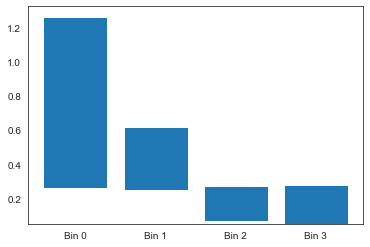

23
0.0 19
-0.04384639380286387 19
-0.043186513388557085 19
0.0414364561535272 20
0.04119958811172317 20
-0.04654179271969883 19
0.04118297623359146 20
-0.043110580349318584 19
0.0375534658541915 20
-0.048393907854503204 19
-0.04519528670733952 19
0.04064208618386758 20
-0.053269000321662055 18
0.007640063363329785 20
0.040733900432503384 20
0.04252886670322631 20
-0.042792042634337946 19
0.04096542924538224 20
-0.051514715203563655 18
0.0 19
0.0329676641737483 20
0.042345657625684596 20
0.039445763245172294 20
0.037901256936077266 20
-0.04485629603410071 19
0.04232308833292908 20
0.0423720420143312 20
-0.05784659871528869 18
0.04668658209205484 20
0.04036632015351049 20
-0.04459552736920652 19
0.04108969978105895 20
0.04075142445133609 20
-0.046393440471900305 19
0.04920374195195909 20
-0.06532440045648413 18
0.042406513143883676 20
0.044239639528428826 20
-0.04798912546565598 19
0.010958978065496533 20
0.04153980881702404 20
-0.04738916321797537 19
0.043040502769350786 20
0.0457201971

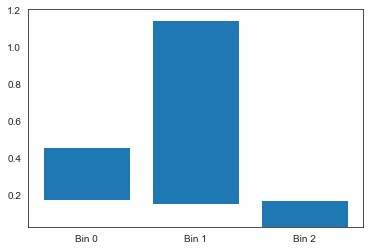

24
0.0 19
0.0 19
-0.0019110313046833416 19
0.008031733425211823 20
0.003396960665379145 20
-0.0011654992909891082 19
0.003759135143916126 20
0.0 19
0.01080415070448637 20
0.0 19
0.0 19
0.0038793554067029223 20
0.0 19
0.0 19
0.010124621680517532 20
0.0036812309284428857 20
-0.002199214367711144 19
0.0035851121969633637 20
-0.0043659246146350306 19
0.0 19
0.003326887318924193 20
0.0039000845616318225 20
0.004717054415801419 20
0.0037876797635298942 20
0.00944838777776134 20
0.0023948572934850976 20
0.003970015673835731 20
0.0 19
0.0036013205156494865 20
0.0035679172548001015 20
0.0 19
0.0033955999293116546 20
0.004604818478083389 20
0.0 19
0.004610937701408718 20
0.0 19
-0.10238607887521896 17
0.0021641018480169083 20
-0.001163298922732231 19
0.0 19
-0.104287858603251 17
-0.001991968163997132 19
0.0025917447187351617 20
0.010991206351052024 20
0.003797740495486701 20
-0.0011148483537970488 19
0.0015212063563481149 20
0.002547617626841303 20
0.002538998114723523 20
0.0 19
0.00371855448700

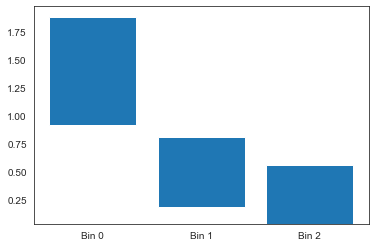

25
0.0 19
-0.002428656060191464 19
-0.0035377784848699134 19
0.0031125714999550302 20
0.0031266584995576496 20
0.0 19
0.0 19
-0.001230132203266343 19
0.002096495596766723 20
0.0 19
-0.0029313568981796656 19
0.001413991017309435 20
0.0 19
0.0 19
0.002340691850943044 20
0.0012946623261509693 20
0.0 19
0.002954497942593115 20
-0.004117385799460027 19
-0.0016863947112494282 19
0.0018815722833215032 20
0.001876886765236896 20
0.0041137409643472456 20
0.00223540413676504 20
0.0 19
0.002410044450649018 20
0.002145625066878598 20
0.0 19
0.003175064063498906 20
0.0017674305766821607 20
-0.0011333159679144944 19
0.0018775875054853342 20
0.002550639278735889 20
-0.0017445255009655436 19
0.0 19
0.0 19
-0.00707492866957272 19
0.004447459689456312 20
-0.0016875637270714061 19
0.0 19
-0.0038491578946489176 19
-0.0015717881529957456 19
0.0015036047928470297 20
0.002439517055541185 20
0.0027357040809750655 20
-0.0032645286474558277 19
0.0 19
0.0009532280569240492 20
0.0 19
0.0 19
0.0011572047006599973 

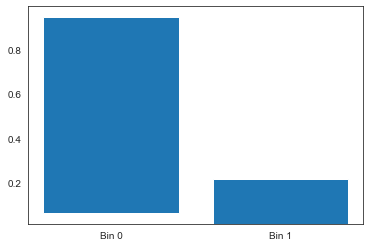

26
-0.020923570510670175 19
-0.027048961940989324 19
-0.025791801762326455 19
0.029613069863646396 20
0.03764438377752269 20
-0.02714502021657736 19
0.03701109245131279 20
-0.026097698332676278 19
0.03940370612654798 20
-0.030288382171544392 19
-0.026134769390478207 19
0.032448135876412154 20
0.025527424474053317 20
-0.02127280547070122 19
0.03694136367600234 20
0.0 19
-0.02904313521036625 19
0.038727014170512386 20
-0.029046339940376753 19
-0.020977713829686995 19
0.03880300338525969 20
0.0352497019336962 20
0.03774507207813116 20
0.03368841291703187 20
0.0666274200322354 21
0.03843640721369762 20
0.03458022979791753 20
-0.024427223093434924 19
0.03360095259112422 20
0.03179089239176677 20
-0.026559298478907423 19
0.03530913572121702 20
0.036239044436656126 20
-0.028055199883100623 19
0.0 19
-0.024988024803059034 19
-0.007191339994132736 19
0.039238466931506844 20
-0.02658163136490857 19
0.04924425334762687 20
-0.006266681466904678 19
-0.02725588894829259 19
0.030870356399039955 20
0.

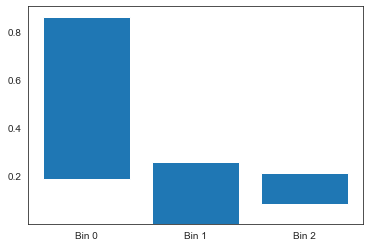

27
-0.05022581235346929 18
-0.031917228072276094 19
-0.03655730490364528 19
0.02905186393294809 20
0.026320113465891137 20
-0.029190692331126478 19
0.03392185208353915 20
-0.02866886998123036 19
0.031911702724729374 20
-0.02841115607819772 19
-0.03253110442387275 19
0.033514504076086526 20
0.013496422055544688 20
0.02194526654228518 20
0.031189359160338243 20
0.0072543049391229075 20
-0.02818416850708716 19
0.03554633501252297 20
-0.035580444439069436 19
-0.04895200619262757 19
0.03799025447391702 20
0.033512170376124306 20
0.03583021027371197 20
0.03407612626194262 20
0.03113813042067997 20
0.032415866445476005 20
0.030890596458058445 20
-0.024686800936560782 19
0.025187240113021536 20
0.03145771877767145 20
-0.027203240333280754 19
0.033311614745290596 20
0.030746980822057873 20
-0.02909386658977442 19
0.007851322274690625 20
-0.01417165750938254 19
-0.04483253890927219 19
0.035787877011899505 20
-0.028768492697900716 19
-0.04444962220796665 19
-0.041786957919933095 19
-0.03135641025

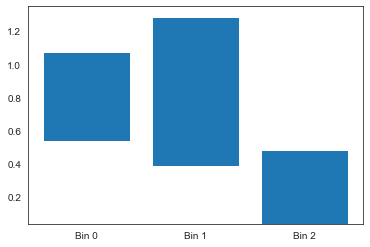

28
0.0 19
0.0 19
-0.004978094632616892 19
0.001956636867639444 20
0.0 19
0.0 19
0.0018868907404068769 20
0.0 19
0.0019273164116589414 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015243809126499475 20
0.0021253001063888943 20
0.0 19
0.0017677542029921334 20
0.0 19
0.0 19
0.002306587961839912 20
0.0 19
0.001967400231130456 20
0.0007040940163837717 20
-0.027605253906207307 19
0.0 19
0.0029666090205738294 20
0.0 19
0.0021766702676590532 20
0.0 19
0.0 19
0.002462795502194415 20
0.0015653955630788863 20
0.0 19
0.0034269091877692226 20
0.0 19
-0.011248097994557294 19
-0.06262310402561932 18
0.0 19
0.0 19
-0.007583498502334926 19
0.0 19
0.0006390825350466034 20
0.00255684953405233 20
0.00217670884892443 20
0.0 19
0.0025033931011794186 20
0.0020553516820460693 20
0.0 19
0.0 19
0.002267205241588355 20
0.0 19
0.0 19
0.0 19
-0.08869625202382525 18
-0.006860768268065975 19
0.0022140685279034567 20
0.0 19
0.001197230239679603 20
0.0 19
0.0 19
0.0012218333641893508 20
0.0 19


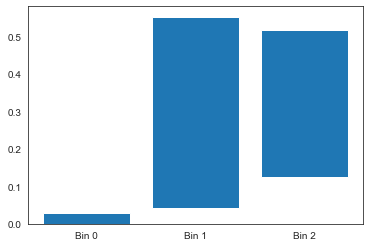

29
0.0 19
0.0 19
0.0 19
0.0018286319010695218 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0013035723981016378 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015487809114542728 20
0.0 19
0.0 19
0.0 19
0.0014613329462757618 20
0.0 19
0.0 19
0.0 19
0.0 19
0.001523243208012226 20
0.0015810751037115267 20
0.0 19
0.0 19
0.0 19
-0.013424777482678634 19
0.0008862924617996093 20
0.0 19
0.0 19
-0.01307785699065321 19
0.0 19
0.0014499730064164718 20
0.002087764069762854 20
0.0006877752571622375 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0021095445322024675 20
0.0 19
0.0 19
0.0 19


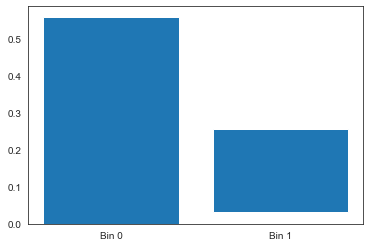

In [38]:
shap_distribs = []
sns.set_style("white")
for i in range(len(feat_list)):
    print (i)
    shap_vals = shap_val_feat[i]
    
    #zscore = scp.stats.zscore(shap_vals)
    
    #print(len(shap_vals))
    #print(each)
    #rel_shap_vals = []
    #for n in range(len(zscore)):
    #    if type(zscore[n]) != float or (zscore[n] < 3 and zscore[n] > -3):
    #        rel_shap_vals.append(shap_vals[n])
    #print(len(rel_shap_vals))

    #shap_min = math.floor(min(rel_shap_vals)*100)/100.0
    #shap_max = math.ceil(max(rel_shap_vals)*100)/100.0
    #print(min(shap_vals), max(shap_vals))
    #print(shap_min, shap_max)
    #bins = np.linspace(shap_min, shap_max+0.01, 20)
    
    bins = np.arange(-1, 1, 0.05)
    
    feat_vals = []
    for sbin in range(len(bins)):
        nl = []
        feat_vals.append(nl)
    
    for j in range(len(shap_vals)):
        val = shap_vals[j]
        b = 0
        cur_bin = bins[b]
        idx = b

        while val > cur_bin:
            #print(cur_bin)
            idx = b
            b+=1
            cur_bin = bins[b]

        print(val, idx)
        feat_vals[idx].append(feats[i][j])
        
    for each in feat_vals:
        zscore = scp.stats.zscore(each)
        #print(each)
        for n in range(len(zscore)):
            if zscore[n] > 3 or zscore[n] < -3:
                np.delete(zscore, n)
                del each[n]
        #print(each)
    #append min and max to dictionary
    mins = []
    maxes = []
    width = []
    #print(feat_vals)
    n = 0
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
            width.append("Bin "+str(n))
            n+=1
    plt.bar(width, maxes, bottom = mins)
    plt.show()
    
    feat_name = feat_list[i]
    
    feat_dict = {'Feature Name': feat_name}
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
        else:
            mins.append(None)
            maxes.append(None)
            
    feat_dict['bins'] = bins
    feat_dict['mins'] = mins
    feat_dict['maxes'] = maxes
    #i = 1
    #for n in range(len(feat_vals)-1):
     #   bin_name = "Bin" + str(i)
      #  i+=1
        
       # shap_range = (bins[n], bins[n+1])
        #if feat_vals[n] != []:
         #   feat_range = (min(feat_vals[n]), max(feat_vals[n]))
        #else:
         #   feat_range = None
        
        #feat_dict[bin_name+"_shap_vals"] = shap_range
        #feat_dict[bin_name+"_feat_vals"] = feat_range
    shap_distribs.append(feat_dict)

In [39]:
def create_samples(shap_explainer, iterations, row, features, top = 10):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        else:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                #print(entry)

        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        for i in range(top):
            feat = importances[i]
            if feat[2] > 0:
                rel_feat.append(feat)
                
        rel_exp.append(rel_feat)
        
    return exp, rel_exp

In [40]:
#shap_stability_scores = []
probas = []
shap_changes = []

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][0]
    probas.append(instance['prediction_probability'][0])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(shap_explainer, 3, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    features = []
    shap_vals = []

    for explanation in rel_exp:
        features.extend([feat[0] for feat in explanation])
        shap_vals.extend([feat for feat in explanation])
        
    #arr = [np.array(x) for x in shap_vals]
    #mean_vals = [np.mean(k) for k in zip(*arr)]
    #print(shap_vals, mean_vals)
    
    counter = Counter(features).most_common(MAX_FEAT)

    feats = [feat[0] for feat in counter]
    
    rel_feats = []
    
    #print(shap_vals)
    
    for feat in feats:
        vals = [i[1] for i in shap_vals if i[0] == feat]
        #print(feat, vals)
        val = np.mean(vals)
        rel_feats.append((feat, val))
    
    intervals = []
    for item in rel_feats:
        feat = item [0]
        val = item[1]
        print("Creating distribution for feature", rel_feats.index(item))
        
        #print(item)
        #print(feat)
        n = feat_list.index(feat)
        feat_dict = shap_distribs[n]
        
        if feat_dict['Feature Name'] != feat:
            for each in distribs:
                if feat_dict['Feature Name'] == feat:
                    feat_dict = each
        
        bins = feat_dict['bins']
        mins = feat_dict['mins']
        maxes = feat_dict['maxes']
        #print (feat, val, bins, mins, maxes)
        
        i = 0
        while val > bins[i]:
            idx = i
            i+=1
        #print (i)
        if mins[i] != None:
            min_val = mins[i]
            max_val = maxes[i]
        else:
            j = i
            while mins[j] == None and j > 0:
                min_val = mins[j-1]
                max_val = maxes[j-1]
                j = j-1
                
        interval = max_val - min_val
        
        index = feat_list.index(feat)
        int_min = max_val
        int_max = max_val + interval
        intervals.append((feature_name, index, int_min, int_max))

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)
    
    shap_changes.append(np.mean(diffs))


INDEX = 41



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 55



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


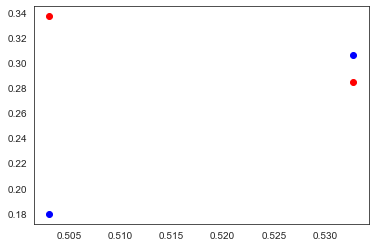

In [41]:
plt.plot(probas, changes, 'bo', label = 'LIME')
plt.plot(probas, shap_changes, 'ro', label = 'SHAP')
plt.show()

In [42]:
#RMSE
sq_changes = []
abs_changes = []
for each in shap_changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
    #change = probas[i] - shap_changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.09713219767146786
RMSE: 0.3116603883580136
MAE: 0.3105446696281433
MAPE: 0.46567702293395996


In [43]:
tree_explainer = shap.TreeExplainer(model)#, data_sample)
shap_values = tree_explainer.shap_values(X_test_frame)
shap_val_feat = np.transpose(shap_values)
feats = np.transpose(X_test_frame.values)

0


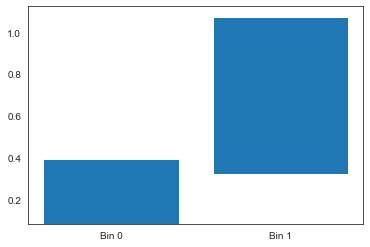

1


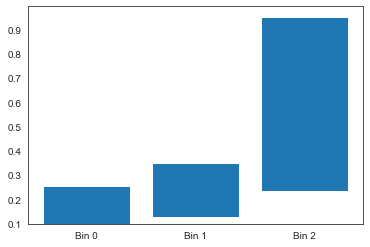

2


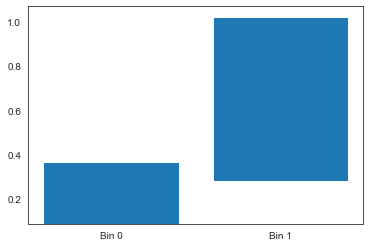

3


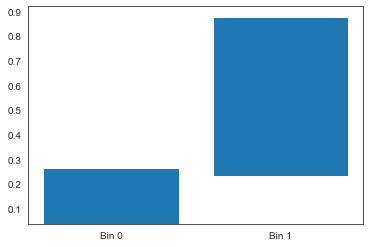

4


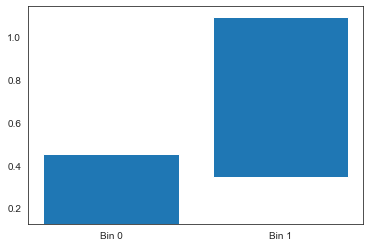

5


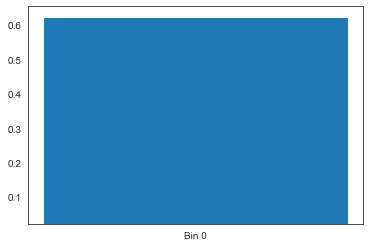

6


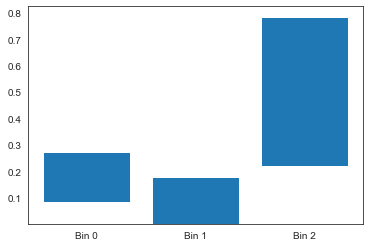

7


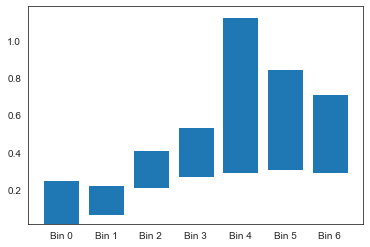

8


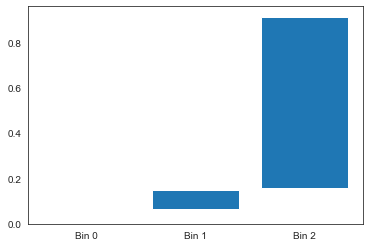

9


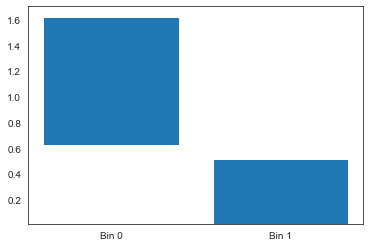

10


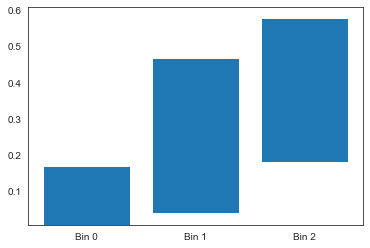

11


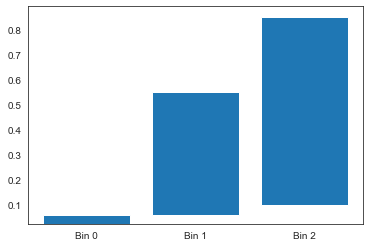

12


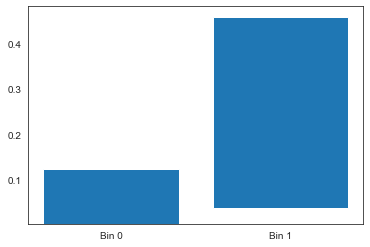

13


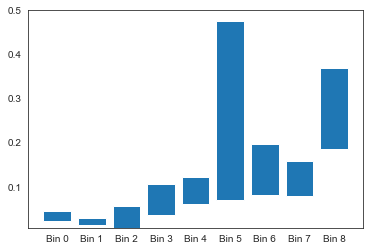

14


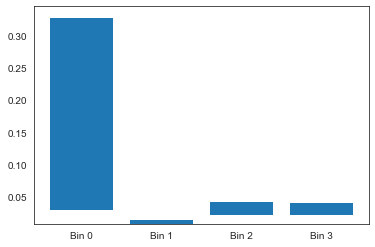

15


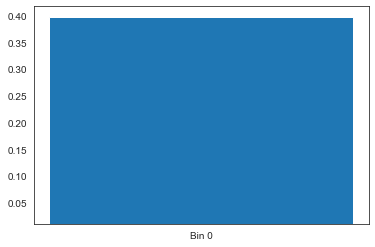

16


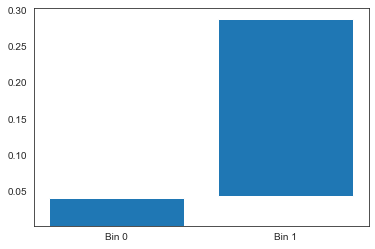

17


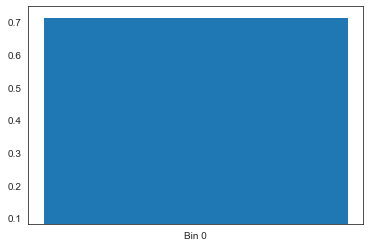

18


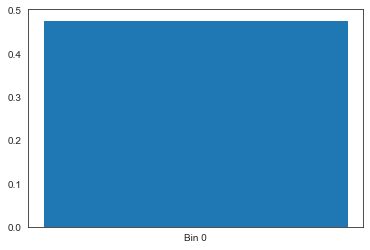

19


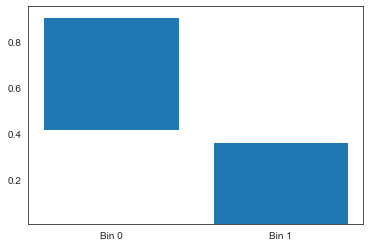

20


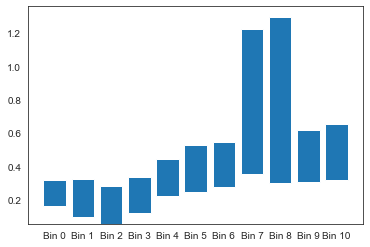

21


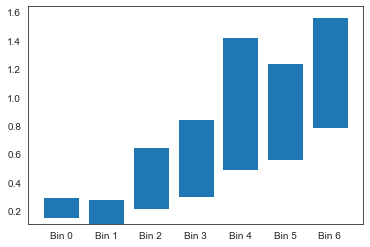

22


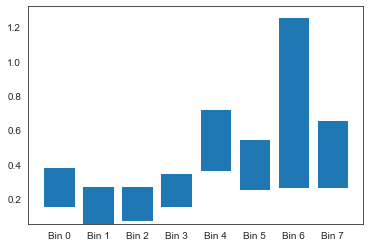

23


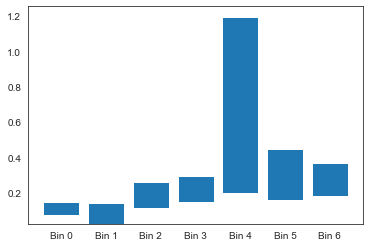

24


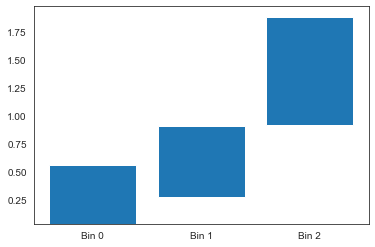

25


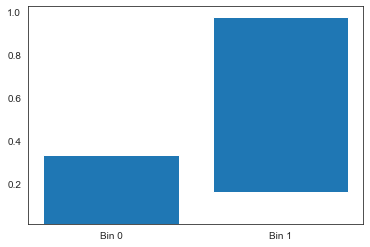

26


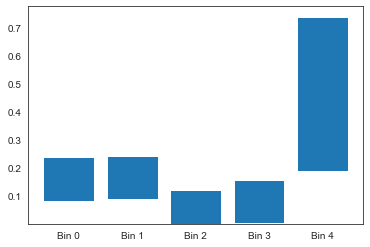

27


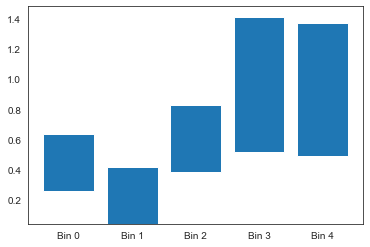

28


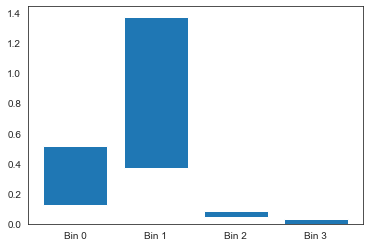

29


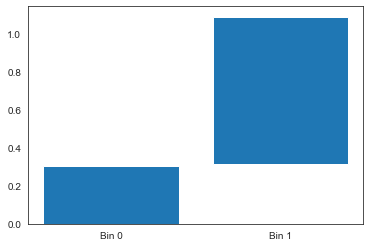

In [44]:
tree_distribs = []
sns.set_style("white")
for i in range(len(feat_list)):
    print (i)
    shap_vals = shap_val_feat[i]
    
    #zscore = scp.stats.zscore(shap_vals)
    
    #print(len(shap_vals))
    #print(each)
    #rel_shap_vals = []
    #for n in range(len(zscore)):
    #    if type(zscore[n]) != float or (zscore[n] < 3 and zscore[n] > -3):
    #        rel_shap_vals.append(shap_vals[n])
    #print(len(rel_shap_vals))

    #shap_min = math.floor(min(rel_shap_vals)*100)/100.0
    #shap_max = math.ceil(max(rel_shap_vals)*100)/100.0
    #print(min(shap_vals), max(shap_vals))
    #print(shap_min, shap_max)
    #bins = np.linspace(shap_min, shap_max+0.01, 20)
    
    bins = np.arange(-1, 1, 0.1)
    
    feat_vals = []
    for sbin in range(len(bins)):
        nl = []
        feat_vals.append(nl)
    
    for j in range(len(shap_vals)):
        val = shap_vals[j]
        b = 0
        cur_bin = bins[b]
        idx = b

        while val > cur_bin:
            #print(cur_bin)
            idx = b
            b+=1
            cur_bin = bins[b]

        #print(val, idx)
        feat_vals[idx].append(feats[i][j])
        
    for each in feat_vals:
        zscore = scp.stats.zscore(each)
        #print(each)
        for n in range(len(zscore)):
            if zscore[n] > 3 or zscore[n] < -3:
                np.delete(zscore, n)
                del each[n]
        #print(each)
    #append min and max to dictionary
    mins = []
    maxes = []
    width = []
    #print(feat_vals)
    n = 0
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
            width.append("Bin "+str(n))
            n+=1
    plt.bar(width, maxes, bottom = mins)
    plt.show()
    
    feat_name = feat_list[i]
    
    feat_dict = {'Feature Name': feat_name}
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
        else:
            mins.append(None)
            maxes.append(None)
            
    feat_dict['bins'] = bins
    feat_dict['mins'] = mins
    feat_dict['maxes'] = maxes
    #i = 1
    #for n in range(len(feat_vals)-1):
     #   bin_name = "Bin" + str(i)
      #  i+=1
        
       # shap_range = (bins[n], bins[n+1])
        #if feat_vals[n] != []:
         #   feat_range = (min(feat_vals[n]), max(feat_vals[n]))
        #else:
         #   feat_range = None
        
        #feat_dict[bin_name+"_shap_vals"] = shap_range
        #feat_dict[bin_name+"_feat_vals"] = feat_range
    tree_distribs.append(feat_dict)

In [45]:
tree_changes = []
probas = []
feat_list = list(feature_names)

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][0]
    probas.append(instance['prediction_probability'][0])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(tree_explainer, 3, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    features = []
    shap_vals = []

    for explanation in rel_exp:
        features.extend([feat[0] for feat in explanation])
        shap_vals.extend([feat for feat in explanation])
        
    #arr = [np.array(x) for x in shap_vals]
    #mean_vals = [np.mean(k) for k in zip(*arr)]
    #print(shap_vals, mean_vals)
    
    counter = Counter(features).most_common(MAX_FEAT)

    feats = [feat[0] for feat in counter]
    
    rel_feats = []
    
    #print(shap_vals)
    
    for feat in feats:
        vals = [i[1] for i in shap_vals if i[0] == feat]
        #print(feat, vals)
        val = np.mean(vals)
        rel_feats.append((feat, val))
    
    intervals = []
    for item in rel_feats:
        feat = item [0]
        val = item[1]
        print("Creating distribution for feature", rel_feats.index(item))
        
        #print(item)
        #print(feat)
        n = feat_list.index(feat)
        feat_dict = tree_distribs[n]
        
        if feat_dict['Feature Name'] != feat:
            for each in distribs:
                if feat_dict['Feature Name'] == feat:
                    feat_dict = each
        
        bins = feat_dict['bins']
        mins = feat_dict['mins']
        maxes = feat_dict['maxes']
        #print (feat, val, bins, mins, maxes)
        
        i = 0
        while val > bins[i]:
            idx = i
            i+=1
        #print (i)
        if mins[i] != None:
            min_val = mins[i]
            max_val = maxes[i]
        else:
            j = i
            while mins[j] == None and j > 0:
                min_val = mins[j-1]
                max_val = maxes[j-1]
                j = j-1
                
        interval = max_val - min_val
        
        index = feat_list.index(feat)
        int_min = max_val
        int_max = max_val + interval
        intervals.append((feature_name, index, int_min, int_max))

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)
    
    tree_changes.append(np.mean(diffs))

INDEX = 41
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 55
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


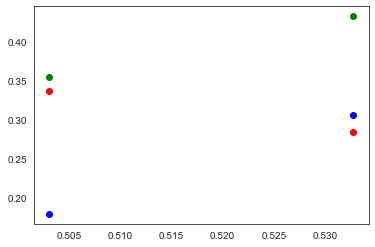

In [46]:
plt.plot(probas, changes, 'bo', label = 'LIME')
plt.plot(probas, shap_changes, 'ro', label = 'SHAP')
plt.plot(probas, tree_changes, 'go', label = 'SHAP')
plt.show()

In [47]:
#RMSE
sq_changes = []
abs_changes = []
for each in tree_changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
    #change = probas[i] - tree_changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.15658224051999925
RMSE: 0.39570473906689474
MAE: 0.3937697559595108
MAPE: 0.46567702293395996


In [48]:
mean_changes = []
rank_corrs = []
IDS = np.arange(1, len(results)+1, 1)
for instance in results:
    patients_feat = pd.Series(instance['scaled_vector'])
    shap_exp, rel_exp = create_samples(shap_explainer, 1, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    tree_exp, rel_exp = create_samples(shap_explainer, 1, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)

    shap_weights = [0]*len(features)
    tree_weights = [0]*len(features)

    for each in features:
        list_idx = feat_list.index(each)
        #print ("Feature", list_idx)
        for explanation in shap_exp[0]:
            #print(explanation)
            if each in explanation[0]:
                shap_weights[list_idx] = explanation[1]
        for explanation in tree_exp[0]:
            if each in explanation[0]:
                tree_weights[list_idx] = explanation[1]

    weight_diff = [abs(shap_weights[i]-tree_weights[i]) for i in range(len(shap_weights))]
    mean_change = np.mean(weight_diff)
    print ('Mean change in shap values:', mean_change)

    shap_ranking = scp.stats.rankdata(shap_weights)
    tree_ranking = scp.stats.rankdata(tree_weights)
    corr, p_val = scp.stats.spearmanr(shap_weights, tree_weights)
    print('Rank Correlation:', corr)
    
    mean_changes.append(mean_change)
    rank_corrs.append(corr)


Mean change in shap values: 0.00016896072997735304
Rank Correlation: 1.0



Mean change in shap values: 0.0004128024590465231
Rank Correlation: 1.0


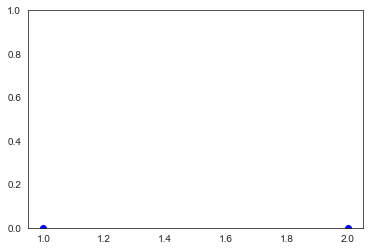

In [49]:
plt.plot(IDS, mean_changes, 'bo')
plt.ylim(0, 1)
plt.show()

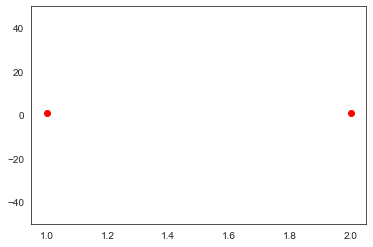

In [50]:
plt.plot(IDS, rank_corrs, 'ro')
plt.ylim(-50,50)
plt.show()

In [51]:
for i in range(len(shap_distribs)):
    print("Kernel:\n", len(shap_distribs[i]['bins']), len(shap_distribs[i]['mins']), len(shap_distribs[i]['maxes']))
    print("Tree:\n", len(tree_distribs[i]['bins']), len(tree_distribs[i]['mins']), len(tree_distribs[i]['maxes']))

Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 44 44
Tree:
 20 27 27
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 44 44
Tree:
 20 29 29
Kernel:
 40 42 42
Tree:
 20 24 24
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 21 21
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 46 46
Tree:
 20 31 31
Kernel:
 40 43 43
Tree:
 20 27 27
Kernel:
 40 44 44
Tree:
 20 28 28
Kernel:
 40 43 43
Tree:
 20 27 27
Kernel:
 40 43 43
Tree:
 20 23 23
Kernel:
 40 42 42
Tree:
 20 22 22
Kernel:
 40 43 43
Tree:
 20 25 25
Kernel:
 40 43 43
Tree:
 20 25 25
Kernel:
 40 43 43
Tree:
 20 24 24
Kernel:
 40 42

In [52]:
for i in range(len(shap_distribs)):
    print("Kernel:\n", shap_distribs[i]['mins'])
    print("Tree:\n", tree_distribs[i]['mins'])

Kernel:
 [0.16314496314496313, 0.08378378378378382, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.16314496314496313, 0.08378378378378382, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Tree:
 [0.08378378378378382, 0.32088452088452085, None, None, None, None, None, None, None, None, None, 0.08378378378378382, 0.32088452088452085, None, None, None, None, None, None, None, None, None]
Kernel:
 [0.23564013840830456, 0.09861591695501731, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.23564013840830456, 0.09861591695501731, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Tree:
 [0.09861591695501731, 0.12595155709342562, 0.23564013840830456, None, None, None, None, None, None, None, None, 0.09861591695501731, 0.12595155709342